# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][1].shape

([0,
  array([ 0.03044579, -0.1611523 , -0.02725059,  0.32642424]),
  1.0,
  False,
  {}],
 (4,))

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.4707520140552726 -3.0241873474478487


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    rewards = tf.placeholder(tf.float32, [None], name='rewards') # env rewards
    rewards2 = tf.placeholder(tf.float32, [None], name='rewards2') # actions logits rewards
    rewards3 = tf.placeholder(tf.float32, [None], name='rewards3') # actions labels rewards
    return states, actions, rewards, rewards2, rewards3

In [8]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [10]:
# Policy learning: past/taken action
# Adverserial/reward learning: current reward optimization
# Q learning: future rewards optimization
def model_loss(action_size, hidden_size, # model init
               states, actions, rewards, rewards2, rewards3): # model input for G & D 
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                       labels=actions_labels))        
    
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    actions_probs = tf.nn.softmax(actions_logits)
    Qs2_logits = discriminator(actions=actions_probs, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    rewards2_logits = tf.nn.sigmoid(Qs2_logits) # total_rewards2
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                    labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
                                                                     labels=tf.reshape(rewards2[1:], shape=[-1, 1])))
    
    #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs3_logits = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rewards3_logits = tf.nn.sigmoid(Qs3_logits) # total_rewards3
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
                                                                    labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
                                                                     labels=tf.reshape(rewards3[1:], shape=[-1, 1])))
    
    # Returning/outputing actions, sum of rewards, rewards, and loss
    return actions_logits, rewards2_logits, rewards3_logits, g_loss, d_loss

In [11]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        gd_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=g_vars)

    return g_opt, d_opt, gd_opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.rewards, self.rewards2, self.rewards3 = model_input(state_size=state_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.rewards2_logits, self.rewards3_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init 
            actions=self.actions, states=self.states, # model input
            rewards=self.rewards, rewards2=self.rewards2, rewards3=self.rewards3) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.gd_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, 
                                                        learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)
print(np.max(actions))
print(np.min(actions))

state size:(1000, 4) actions:(1000,)
2
1
0


In [14]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [15]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
env.reset()

array([0.02139072, 0.02794812, 0.02961668, 0.00786599])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
state, reward, action

(array([ 0.03179866, -0.20257098,  0.02501544,  0.32116478]), 1.0, 0)

In [44]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            action *= 1 - float(done) # last action is always 0
            batch.append([state, action])
            state = next_state
            total_reward += reward
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states,
                                                                     model.actions: actions})
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Batch loss: {:.9f}'.format(loss))
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, loss])
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-g.ckpt')

Episode: 0 Total reward: 8.0 Batch loss: 0.671419621
Episode: 1 Total reward: 10.0 Batch loss: 0.638826668
Episode: 2 Total reward: 10.0 Batch loss: 0.621340215
Episode: 3 Total reward: 10.0 Batch loss: 0.599634111
Episode: 4 Total reward: 9.0 Batch loss: 0.594268322
Episode: 5 Total reward: 9.0 Batch loss: 0.579007685
Episode: 6 Total reward: 10.0 Batch loss: 0.549144149
Episode: 7 Total reward: 8.0 Batch loss: 0.577575445
Episode: 8 Total reward: 8.0 Batch loss: 0.566001296
Episode: 9 Total reward: 10.0 Batch loss: 0.527015984
Episode: 10 Total reward: 10.0 Batch loss: 0.517194867
Episode: 11 Total reward: 10.0 Batch loss: 0.510718584
Episode: 12 Total reward: 9.0 Batch loss: 0.528295994
Episode: 13 Total reward: 10.0 Batch loss: 0.505321681
Episode: 14 Total reward: 10.0 Batch loss: 0.498425663
Episode: 15 Total reward: 9.0 Batch loss: 0.516105533
Episode: 16 Total reward: 9.0 Batch loss: 0.509920776
Episode: 17 Total reward: 9.0 Batch loss: 0.510373354
Episode: 18 Total reward: 9.0

Episode: 156 Total reward: 18.0 Batch loss: 0.174539074
Episode: 157 Total reward: 18.0 Batch loss: 0.173664168
Episode: 158 Total reward: 18.0 Batch loss: 0.181965545
Episode: 159 Total reward: 16.0 Batch loss: 0.169784784
Episode: 160 Total reward: 22.0 Batch loss: 0.181935921
Episode: 161 Total reward: 22.0 Batch loss: 0.358850598
Episode: 162 Total reward: 26.0 Batch loss: 0.167402267
Episode: 163 Total reward: 21.0 Batch loss: 0.178902104
Episode: 164 Total reward: 19.0 Batch loss: 0.157319278
Episode: 165 Total reward: 16.0 Batch loss: 0.153511524
Episode: 166 Total reward: 27.0 Batch loss: 0.131974190
Episode: 167 Total reward: 32.0 Batch loss: 0.150662303
Episode: 168 Total reward: 31.0 Batch loss: 0.112088159
Episode: 169 Total reward: 27.0 Batch loss: 0.116992883
Episode: 170 Total reward: 29.0 Batch loss: 0.275541127
Episode: 171 Total reward: 24.0 Batch loss: 0.141388789
Episode: 172 Total reward: 33.0 Batch loss: 0.109511860
Episode: 173 Total reward: 27.0 Batch loss: 0.09

Episode: 302 Total reward: 200.0 Batch loss: 0.230164379
Episode: 303 Total reward: 177.0 Batch loss: 0.063555367
Episode: 304 Total reward: 84.0 Batch loss: 0.104573742
Episode: 305 Total reward: 88.0 Batch loss: 0.123910978
Episode: 306 Total reward: 90.0 Batch loss: 0.093174942
Episode: 307 Total reward: 200.0 Batch loss: 0.226937965
Episode: 308 Total reward: 200.0 Batch loss: 0.309851915
Episode: 309 Total reward: 200.0 Batch loss: 0.184467450
Episode: 310 Total reward: 200.0 Batch loss: 0.279127628
Episode: 311 Total reward: 200.0 Batch loss: 0.271389186
Episode: 312 Total reward: 200.0 Batch loss: 0.296923041
Episode: 313 Total reward: 200.0 Batch loss: 0.317128778
Episode: 314 Total reward: 200.0 Batch loss: 0.302332938
Episode: 315 Total reward: 161.0 Batch loss: 0.083013713
Episode: 316 Total reward: 200.0 Batch loss: 0.304222882
Episode: 317 Total reward: 99.0 Batch loss: 0.047897585
Episode: 318 Total reward: 200.0 Batch loss: 0.295153379
Episode: 319 Total reward: 200.0 Ba

Episode: 446 Total reward: 200.0 Batch loss: 0.334891349
Episode: 447 Total reward: 101.0 Batch loss: 0.042660028
Episode: 448 Total reward: 200.0 Batch loss: 0.243027940
Episode: 449 Total reward: 200.0 Batch loss: 0.271478802
Episode: 450 Total reward: 84.0 Batch loss: 0.094830647
Episode: 451 Total reward: 200.0 Batch loss: 0.143686116
Episode: 452 Total reward: 200.0 Batch loss: 0.288492829
Episode: 453 Total reward: 200.0 Batch loss: 0.268936872
Episode: 454 Total reward: 78.0 Batch loss: 0.102096774
Episode: 455 Total reward: 200.0 Batch loss: 0.342536151
Episode: 456 Total reward: 200.0 Batch loss: 0.264916152
Episode: 457 Total reward: 200.0 Batch loss: 0.195639059
Episode: 458 Total reward: 200.0 Batch loss: 0.176670194
Episode: 459 Total reward: 200.0 Batch loss: 0.281299740
Episode: 460 Total reward: 93.0 Batch loss: 0.042720892
Episode: 461 Total reward: 169.0 Batch loss: 0.072060347
Episode: 462 Total reward: 200.0 Batch loss: 0.313027084
Episode: 463 Total reward: 178.0 B

Episode: 590 Total reward: 200.0 Batch loss: 0.309176534
Episode: 591 Total reward: 200.0 Batch loss: 0.273352653
Episode: 592 Total reward: 200.0 Batch loss: 0.319950074
Episode: 593 Total reward: 200.0 Batch loss: 0.278921455
Episode: 594 Total reward: 200.0 Batch loss: 0.335642785
Episode: 595 Total reward: 200.0 Batch loss: 0.263368517
Episode: 596 Total reward: 177.0 Batch loss: 0.080416888
Episode: 597 Total reward: 200.0 Batch loss: 0.270572156
Episode: 598 Total reward: 67.0 Batch loss: 0.087333009
Episode: 599 Total reward: 200.0 Batch loss: 0.155423373
Episode: 600 Total reward: 200.0 Batch loss: 0.254262120
Episode: 601 Total reward: 200.0 Batch loss: 0.285211742
Episode: 602 Total reward: 200.0 Batch loss: 0.234939054
Episode: 603 Total reward: 200.0 Batch loss: 0.336304635
Episode: 604 Total reward: 200.0 Batch loss: 0.208592594
Episode: 605 Total reward: 200.0 Batch loss: 0.302653044
Episode: 606 Total reward: 200.0 Batch loss: 0.271813482
Episode: 607 Total reward: 200.0

Episode: 736 Total reward: 200.0 Batch loss: 0.251563162
Episode: 737 Total reward: 186.0 Batch loss: 0.083541267
Episode: 738 Total reward: 188.0 Batch loss: 0.025743702
Episode: 739 Total reward: 200.0 Batch loss: 0.283272237
Episode: 740 Total reward: 200.0 Batch loss: 0.313621163
Episode: 741 Total reward: 70.0 Batch loss: 0.114745982
Episode: 742 Total reward: 200.0 Batch loss: 0.264264047
Episode: 743 Total reward: 200.0 Batch loss: 0.199624941
Episode: 744 Total reward: 200.0 Batch loss: 0.261564821
Episode: 745 Total reward: 200.0 Batch loss: 0.231608927
Episode: 746 Total reward: 200.0 Batch loss: 0.207160383
Episode: 747 Total reward: 200.0 Batch loss: 0.191349894
Episode: 748 Total reward: 200.0 Batch loss: 0.216948017
Episode: 749 Total reward: 200.0 Batch loss: 0.208159700
Episode: 750 Total reward: 200.0 Batch loss: 0.243477523
Episode: 751 Total reward: 200.0 Batch loss: 0.185964629
Episode: 752 Total reward: 94.0 Batch loss: 0.103453055
Episode: 753 Total reward: 200.0 

Episode: 881 Total reward: 200.0 Batch loss: 0.266822457
Episode: 882 Total reward: 200.0 Batch loss: 0.231403813
Episode: 883 Total reward: 200.0 Batch loss: 0.271646589
Episode: 884 Total reward: 200.0 Batch loss: 0.210340157
Episode: 885 Total reward: 80.0 Batch loss: 0.041870899
Episode: 886 Total reward: 92.0 Batch loss: 0.043724466
Episode: 887 Total reward: 200.0 Batch loss: 0.272338957
Episode: 888 Total reward: 200.0 Batch loss: 0.244442031
Episode: 889 Total reward: 200.0 Batch loss: 0.164975286
Episode: 890 Total reward: 200.0 Batch loss: 0.223299727
Episode: 891 Total reward: 200.0 Batch loss: 0.244490415
Episode: 892 Total reward: 200.0 Batch loss: 0.256378084
Episode: 893 Total reward: 200.0 Batch loss: 0.257400781
Episode: 894 Total reward: 200.0 Batch loss: 0.229804531
Episode: 895 Total reward: 200.0 Batch loss: 0.267502546
Episode: 896 Total reward: 200.0 Batch loss: 0.219227970
Episode: 897 Total reward: 200.0 Batch loss: 0.249892250
Episode: 898 Total reward: 200.0 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

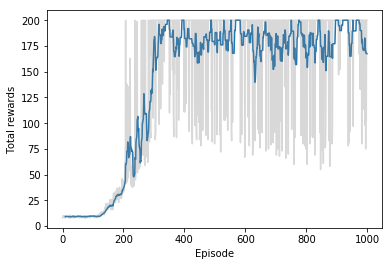

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Batch losses')

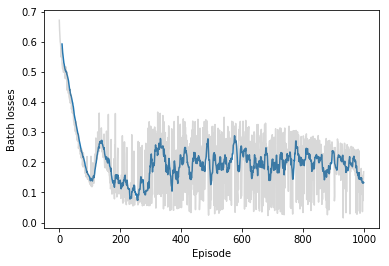

In [47]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch losses')

## Testing

Let's checkout how our trained agent plays the game.

In [48]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

# Now train with experiences
saver = tf.train.Saver()

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-gd.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-g.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.

In [49]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [50]:
# Env reward, action logits reward, action labels/onehot reward
rewards_list, rewards2_list, rewards3_list, gloss_list, dloss_list = [], [], [], [], []

# TF session for training
with tf.Session() as sess:
    
    # Rstoring/loading the trained/learned controller SA/SM
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    #train_episodes = 100
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0 # reward env
        total_reward2 = 0 # reward action logits
        total_reward3 = 0 # reward action onehot/labels

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits, reward2, reward3 = sess.run([model.actions_logits, 
                                                        model.rewards2_logits, 
                                                        model.rewards3_logits],
                                                       feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                                  model.actions: np.array([action])})
                                                                  #model.actions: np.reshape(action, [-1])})
            #print(reward2[0, 0], reward3.reshape(-1))
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward # env
            total_reward2 += reward2[0, 0] #_action_logits
            total_reward3 += reward3[0, 0] #_actions_labels
            # state & action pair for policy learning: current policy/action
            # reward for adverserial/reward learning: current reward/value
            # reward2 and reward3 for value/Q learning: future rewards/value
            batch.append([state, action, reward, reward2[0, 0], reward3[0, 0]])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        rewards2 = np.array([each[3] for each in batch])
        rewards3 = np.array([each[4] for each in batch])
        g_loss, d_loss, _ = sess.run([model.g_loss, model.d_loss, model.d_opt], 
                                     feed_dict = {model.states: states,
                                                  model.actions: actions, 
                                                  model.rewards:rewards, 
                                                  model.rewards2:rewards2, 
                                                  model.rewards3:rewards3})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'total_reward2: {:.4f}'.format(total_reward2),
              'total_reward3: {:.4f}'.format(total_reward3),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        rewards_list.append([ep, total_reward])
        rewards2_list.append([ep, total_reward2])
        rewards3_list.append([ep, total_reward3])
        gloss_list.append([ep, g_loss])
        dloss_list.append([ep, d_loss])
        
    # Save the trained/learned D using G/SM/SA
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-g-d.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/model-g.ckpt
Episode: 0 total_reward: 500.0 total_reward2: 236.3721 total_reward3: 236.7222 g_loss: 0.1807 d_loss: 2.8768
Episode: 1 total_reward: 500.0 total_reward2: 242.3265 total_reward3: 243.3818 g_loss: 0.1886 d_loss: 2.8268
Episode: 2 total_reward: 500.0 total_reward2: 247.6300 total_reward3: 249.1896 g_loss: 0.1906 d_loss: 2.7831
Episode: 3 total_reward: 500.0 total_reward2: 251.7562 total_reward3: 252.7719 g_loss: 0.1414 d_loss: 2.7524
Episode: 4 total_reward: 448.0 total_reward2: 231.2514 total_reward3: 232.2092 g_loss: 0.1380 d_loss: 2.7019
Episode: 5 total_reward: 500.0 total_reward2: 264.6852 total_reward3: 267.0413 g_loss: 0.1752 d_loss: 2.6461
Episode: 6 total_reward: 500.0 total_reward2: 270.7847 total_reward3: 273.3409 g_loss: 0.1771 d_loss: 2.5964
Episode: 7 total_reward: 500.0 total_reward2: 274.6322 total_reward3: 278.1828 g_loss: 0.1736 d_loss: 2.5652
Episode: 8 total_reward: 500.0 total_reward2: 282.0455 total_

Episode: 75 total_reward: 500.0 total_reward2: 495.6044 total_reward3: 496.0712 g_loss: 0.1833 d_loss: 0.1133
Episode: 76 total_reward: 500.0 total_reward2: 496.3037 total_reward3: 496.6846 g_loss: 0.1490 d_loss: 0.0978
Episode: 77 total_reward: 500.0 total_reward2: 496.1234 total_reward3: 496.5294 g_loss: 0.1765 d_loss: 0.1018
Episode: 78 total_reward: 500.0 total_reward2: 493.6073 total_reward3: 494.1928 g_loss: 0.1769 d_loss: 0.1567
Episode: 79 total_reward: 500.0 total_reward2: 495.0367 total_reward3: 495.4242 g_loss: 0.1792 d_loss: 0.1274
Episode: 80 total_reward: 500.0 total_reward2: 495.2016 total_reward3: 495.5442 g_loss: 0.1857 d_loss: 0.1240
Episode: 81 total_reward: 500.0 total_reward2: 495.3641 total_reward3: 495.7209 g_loss: 0.1833 d_loss: 0.1202
Episode: 82 total_reward: 500.0 total_reward2: 495.7999 total_reward3: 496.1363 g_loss: 0.1858 d_loss: 0.1104
Episode: 83 total_reward: 444.0 total_reward2: 441.7462 total_reward3: 441.9524 g_loss: 0.1348 d_loss: 0.0709
Episode: 8

Episode: 151 total_reward: 500.0 total_reward2: 499.2070 total_reward3: 499.2548 g_loss: 0.1746 d_loss: 0.0261
Episode: 152 total_reward: 500.0 total_reward2: 499.0524 total_reward3: 499.0853 g_loss: 0.1741 d_loss: 0.0309
Episode: 153 total_reward: 500.0 total_reward2: 498.9597 total_reward3: 499.0103 g_loss: 0.1801 d_loss: 0.0333
Episode: 154 total_reward: 500.0 total_reward2: 498.9809 total_reward3: 499.0323 g_loss: 0.1705 d_loss: 0.0327
Episode: 155 total_reward: 500.0 total_reward2: 499.0023 total_reward3: 499.0495 g_loss: 0.1797 d_loss: 0.0321
Episode: 156 total_reward: 261.0 total_reward2: 260.3774 total_reward3: 260.4245 g_loss: 0.1719 d_loss: 0.0370
Episode: 157 total_reward: 500.0 total_reward2: 499.0031 total_reward3: 499.0459 g_loss: 0.1739 d_loss: 0.0321
Episode: 158 total_reward: 500.0 total_reward2: 499.1000 total_reward3: 499.1324 g_loss: 0.1672 d_loss: 0.0295
Episode: 159 total_reward: 500.0 total_reward2: 499.0806 total_reward3: 499.1191 g_loss: 0.1723 d_loss: 0.0300
E

Episode: 225 total_reward: 500.0 total_reward2: 499.6021 total_reward3: 499.6125 g_loss: 0.1803 d_loss: 0.0144
Episode: 226 total_reward: 500.0 total_reward2: 499.6172 total_reward3: 499.6271 g_loss: 0.1813 d_loss: 0.0139
Episode: 227 total_reward: 500.0 total_reward2: 499.6635 total_reward3: 499.6754 g_loss: 0.1642 d_loss: 0.0123
Episode: 228 total_reward: 500.0 total_reward2: 499.6640 total_reward3: 499.6749 g_loss: 0.1842 d_loss: 0.0123
Episode: 229 total_reward: 500.0 total_reward2: 499.5621 total_reward3: 499.5779 g_loss: 0.1852 d_loss: 0.0156
Episode: 230 total_reward: 500.0 total_reward2: 499.5914 total_reward3: 499.6037 g_loss: 0.1816 d_loss: 0.0147
Episode: 231 total_reward: 500.0 total_reward2: 499.6387 total_reward3: 499.6476 g_loss: 0.1644 d_loss: 0.0132
Episode: 232 total_reward: 500.0 total_reward2: 499.5986 total_reward3: 499.6112 g_loss: 0.1613 d_loss: 0.0144
Episode: 233 total_reward: 500.0 total_reward2: 499.6389 total_reward3: 499.6490 g_loss: 0.1804 d_loss: 0.0132
E

Episode: 299 total_reward: 500.0 total_reward2: 499.7966 total_reward3: 499.8011 g_loss: 0.1715 d_loss: 0.0079
Episode: 300 total_reward: 139.0 total_reward2: 138.9353 total_reward3: 138.9343 g_loss: 0.0237 d_loss: 0.0091
Episode: 301 total_reward: 500.0 total_reward2: 499.7550 total_reward3: 499.7640 g_loss: 0.1797 d_loss: 0.0093
Episode: 302 total_reward: 313.0 total_reward2: 312.9420 total_reward3: 312.9443 g_loss: 0.0637 d_loss: 0.0038
Episode: 303 total_reward: 500.0 total_reward2: 499.8664 total_reward3: 499.8730 g_loss: 0.1811 d_loss: 0.0053
Episode: 304 total_reward: 500.0 total_reward2: 499.8768 total_reward3: 499.8827 g_loss: 0.1486 d_loss: 0.0049
Episode: 305 total_reward: 500.0 total_reward2: 499.8011 total_reward3: 499.8049 g_loss: 0.1708 d_loss: 0.0077
Episode: 306 total_reward: 458.0 total_reward2: 457.9033 total_reward3: 457.9081 g_loss: 0.1346 d_loss: 0.0043
Episode: 307 total_reward: 500.0 total_reward2: 499.7882 total_reward3: 499.7927 g_loss: 0.1804 d_loss: 0.0082
E

Episode: 373 total_reward: 500.0 total_reward2: 499.8870 total_reward3: 499.8899 g_loss: 0.1905 d_loss: 0.0046
Episode: 374 total_reward: 500.0 total_reward2: 499.8672 total_reward3: 499.8695 g_loss: 0.1751 d_loss: 0.0054
Episode: 375 total_reward: 96.0 total_reward2: 95.9729 total_reward3: 95.9721 g_loss: 0.0279 d_loss: 0.0058
Episode: 376 total_reward: 98.0 total_reward2: 97.9724 total_reward3: 97.9717 g_loss: 0.0319 d_loss: 0.0058
Episode: 377 total_reward: 500.0 total_reward2: 499.8690 total_reward3: 499.8706 g_loss: 0.1658 d_loss: 0.0053
Episode: 378 total_reward: 500.0 total_reward2: 499.8819 total_reward3: 499.8845 g_loss: 0.1741 d_loss: 0.0048
Episode: 379 total_reward: 500.0 total_reward2: 499.8604 total_reward3: 499.8616 g_loss: 0.1754 d_loss: 0.0057
Episode: 380 total_reward: 500.0 total_reward2: 499.8909 total_reward3: 499.8926 g_loss: 0.1817 d_loss: 0.0045
Episode: 381 total_reward: 500.0 total_reward2: 499.9315 total_reward3: 499.9349 g_loss: 0.1472 d_loss: 0.0029
Episode

Episode: 447 total_reward: 500.0 total_reward2: 499.8964 total_reward3: 499.8987 g_loss: 0.1850 d_loss: 0.0043
Episode: 448 total_reward: 256.0 total_reward2: 255.9368 total_reward3: 255.9407 g_loss: 0.1668 d_loss: 0.0049
Episode: 449 total_reward: 443.0 total_reward2: 442.9604 total_reward3: 442.9623 g_loss: 0.1398 d_loss: 0.0020
Episode: 450 total_reward: 500.0 total_reward2: 499.9074 total_reward3: 499.9074 g_loss: 0.1806 d_loss: 0.0039
Episode: 451 total_reward: 132.0 total_reward2: 131.9749 total_reward3: 131.9743 g_loss: 0.0264 d_loss: 0.0041
Episode: 452 total_reward: 500.0 total_reward2: 499.8931 total_reward3: 499.8962 g_loss: 0.1899 d_loss: 0.0044
Episode: 453 total_reward: 432.0 total_reward2: 431.9632 total_reward3: 431.9651 g_loss: 0.1361 d_loss: 0.0019
Episode: 454 total_reward: 500.0 total_reward2: 499.9022 total_reward3: 499.9036 g_loss: 0.1754 d_loss: 0.0041
Episode: 455 total_reward: 500.0 total_reward2: 499.9279 total_reward3: 499.9294 g_loss: 0.1908 d_loss: 0.0031
E

Episode: 521 total_reward: 500.0 total_reward2: 499.9375 total_reward3: 499.9376 g_loss: 0.1773 d_loss: 0.0027
Episode: 522 total_reward: 145.0 total_reward2: 144.9788 total_reward3: 144.9780 g_loss: 0.0254 d_loss: 0.0032
Episode: 523 total_reward: 500.0 total_reward2: 499.9394 total_reward3: 499.9400 g_loss: 0.1761 d_loss: 0.0027
Episode: 524 total_reward: 500.0 total_reward2: 499.9220 total_reward3: 499.9233 g_loss: 0.1785 d_loss: 0.0033
Episode: 525 total_reward: 500.0 total_reward2: 499.9459 total_reward3: 499.9465 g_loss: 0.1920 d_loss: 0.0024
Episode: 526 total_reward: 500.0 total_reward2: 499.9371 total_reward3: 499.9373 g_loss: 0.1770 d_loss: 0.0028
Episode: 527 total_reward: 500.0 total_reward2: 499.9299 total_reward3: 499.9305 g_loss: 0.1694 d_loss: 0.0030
Episode: 528 total_reward: 500.0 total_reward2: 499.9463 total_reward3: 499.9469 g_loss: 0.1917 d_loss: 0.0024
Episode: 529 total_reward: 500.0 total_reward2: 499.9637 total_reward3: 499.9651 g_loss: 0.1696 d_loss: 0.0016
E

Episode: 595 total_reward: 446.0 total_reward2: 445.9781 total_reward3: 445.9789 g_loss: 0.1383 d_loss: 0.0011
Episode: 596 total_reward: 500.0 total_reward2: 499.9541 total_reward3: 499.9542 g_loss: 0.1775 d_loss: 0.0021
Episode: 597 total_reward: 500.0 total_reward2: 499.9555 total_reward3: 499.9554 g_loss: 0.1756 d_loss: 0.0020
Episode: 598 total_reward: 500.0 total_reward2: 499.9518 total_reward3: 499.9519 g_loss: 0.1798 d_loss: 0.0022
Episode: 599 total_reward: 500.0 total_reward2: 499.9438 total_reward3: 499.9442 g_loss: 0.1666 d_loss: 0.0025
Episode: 600 total_reward: 500.0 total_reward2: 499.9708 total_reward3: 499.9719 g_loss: 0.1723 d_loss: 0.0013
Episode: 601 total_reward: 304.0 total_reward2: 303.9872 total_reward3: 303.9876 g_loss: 0.0826 d_loss: 0.0010
Episode: 602 total_reward: 346.0 total_reward2: 345.9842 total_reward3: 345.9846 g_loss: 0.0870 d_loss: 0.0011
Episode: 603 total_reward: 500.0 total_reward2: 499.9543 total_reward3: 499.9544 g_loss: 0.1824 d_loss: 0.0021
E

Episode: 669 total_reward: 500.0 total_reward2: 499.9560 total_reward3: 499.9559 g_loss: 0.1835 d_loss: 0.0020
Episode: 670 total_reward: 500.0 total_reward2: 499.9546 total_reward3: 499.9548 g_loss: 0.1800 d_loss: 0.0020
Episode: 671 total_reward: 495.0 total_reward2: 494.9804 total_reward3: 494.9810 g_loss: 0.1313 d_loss: 0.0009
Episode: 672 total_reward: 96.0 total_reward2: 95.9923 total_reward3: 95.9920 g_loss: 0.0353 d_loss: 0.0019
Episode: 673 total_reward: 112.0 total_reward2: 111.9908 total_reward3: 111.9904 g_loss: 0.0309 d_loss: 0.0019
Episode: 674 total_reward: 500.0 total_reward2: 499.9555 total_reward3: 499.9559 g_loss: 0.1834 d_loss: 0.0020
Episode: 675 total_reward: 500.0 total_reward2: 499.9599 total_reward3: 499.9597 g_loss: 0.1789 d_loss: 0.0018
Episode: 676 total_reward: 500.0 total_reward2: 499.9780 total_reward3: 499.9787 g_loss: 0.1649 d_loss: 0.0010
Episode: 677 total_reward: 500.0 total_reward2: 499.9600 total_reward3: 499.9595 g_loss: 0.1797 d_loss: 0.0018
Epis

Episode: 743 total_reward: 500.0 total_reward2: 499.9746 total_reward3: 499.9745 g_loss: 0.1894 d_loss: 0.0012
Episode: 744 total_reward: 500.0 total_reward2: 499.9631 total_reward3: 499.9632 g_loss: 0.1864 d_loss: 0.0017
Episode: 745 total_reward: 500.0 total_reward2: 499.9617 total_reward3: 499.9622 g_loss: 0.1928 d_loss: 0.0017
Episode: 746 total_reward: 500.0 total_reward2: 499.9660 total_reward3: 499.9657 g_loss: 0.1758 d_loss: 0.0016
Episode: 747 total_reward: 500.0 total_reward2: 499.9637 total_reward3: 499.9637 g_loss: 0.1832 d_loss: 0.0017
Episode: 748 total_reward: 432.0 total_reward2: 431.9873 total_reward3: 431.9877 g_loss: 0.1247 d_loss: 0.0007
Episode: 749 total_reward: 500.0 total_reward2: 499.9729 total_reward3: 499.9728 g_loss: 0.1836 d_loss: 0.0013
Episode: 750 total_reward: 448.0 total_reward2: 447.9865 total_reward3: 447.9869 g_loss: 0.1338 d_loss: 0.0007
Episode: 751 total_reward: 500.0 total_reward2: 499.9693 total_reward3: 499.9689 g_loss: 0.1790 d_loss: 0.0014
E

Episode: 817 total_reward: 500.0 total_reward2: 499.9770 total_reward3: 499.9766 g_loss: 0.1775 d_loss: 0.0011
Episode: 818 total_reward: 500.0 total_reward2: 499.9693 total_reward3: 499.9695 g_loss: 0.1822 d_loss: 0.0014
Episode: 819 total_reward: 102.0 total_reward2: 101.9948 total_reward3: 101.9945 g_loss: 0.0294 d_loss: 0.0012
Episode: 820 total_reward: 500.0 total_reward2: 499.9795 total_reward3: 499.9796 g_loss: 0.1858 d_loss: 0.0010
Episode: 821 total_reward: 500.0 total_reward2: 499.9776 total_reward3: 499.9774 g_loss: 0.1800 d_loss: 0.0011
Episode: 822 total_reward: 500.0 total_reward2: 499.9740 total_reward3: 499.9736 g_loss: 0.1786 d_loss: 0.0012
Episode: 823 total_reward: 500.0 total_reward2: 499.9728 total_reward3: 499.9725 g_loss: 0.1776 d_loss: 0.0013
Episode: 824 total_reward: 500.0 total_reward2: 499.9768 total_reward3: 499.9764 g_loss: 0.1706 d_loss: 0.0011
Episode: 825 total_reward: 500.0 total_reward2: 499.9778 total_reward3: 499.9776 g_loss: 0.1841 d_loss: 0.0011
E

Episode: 891 total_reward: 436.0 total_reward2: 435.9913 total_reward3: 435.9915 g_loss: 0.1322 d_loss: 0.0005
Episode: 892 total_reward: 500.0 total_reward2: 499.9821 total_reward3: 499.9820 g_loss: 0.1805 d_loss: 0.0009
Episode: 893 total_reward: 500.0 total_reward2: 499.9816 total_reward3: 499.9813 g_loss: 0.1873 d_loss: 0.0009
Episode: 894 total_reward: 500.0 total_reward2: 499.9803 total_reward3: 499.9800 g_loss: 0.1706 d_loss: 0.0010
Episode: 895 total_reward: 500.0 total_reward2: 499.9824 total_reward3: 499.9821 g_loss: 0.1845 d_loss: 0.0009
Episode: 896 total_reward: 500.0 total_reward2: 499.9824 total_reward3: 499.9821 g_loss: 0.1720 d_loss: 0.0009
Episode: 897 total_reward: 500.0 total_reward2: 499.9804 total_reward3: 499.9801 g_loss: 0.1734 d_loss: 0.0010
Episode: 898 total_reward: 104.0 total_reward2: 103.9956 total_reward3: 103.9953 g_loss: 0.0271 d_loss: 0.0011
Episode: 899 total_reward: 500.0 total_reward2: 499.9795 total_reward3: 499.9790 g_loss: 0.1815 d_loss: 0.0010
E

Episode: 965 total_reward: 500.0 total_reward2: 499.9798 total_reward3: 499.9795 g_loss: 0.1817 d_loss: 0.0010
Episode: 966 total_reward: 492.0 total_reward2: 491.9914 total_reward3: 491.9915 g_loss: 0.1375 d_loss: 0.0004
Episode: 967 total_reward: 500.0 total_reward2: 499.9796 total_reward3: 499.9793 g_loss: 0.1736 d_loss: 0.0010
Episode: 968 total_reward: 500.0 total_reward2: 499.9864 total_reward3: 499.9862 g_loss: 0.1641 d_loss: 0.0007
Episode: 969 total_reward: 500.0 total_reward2: 499.9787 total_reward3: 499.9786 g_loss: 0.1878 d_loss: 0.0010
Episode: 970 total_reward: 500.0 total_reward2: 499.9834 total_reward3: 499.9831 g_loss: 0.1791 d_loss: 0.0008
Episode: 971 total_reward: 500.0 total_reward2: 499.9850 total_reward3: 499.9848 g_loss: 0.1850 d_loss: 0.0007
Episode: 972 total_reward: 431.0 total_reward2: 430.9929 total_reward3: 430.9930 g_loss: 0.1201 d_loss: 0.0004
Episode: 973 total_reward: 94.0 total_reward2: 93.9969 total_reward3: 93.9967 g_loss: 0.0274 d_loss: 0.0008
Epis

Text(0,0.5,'Total env rewards')

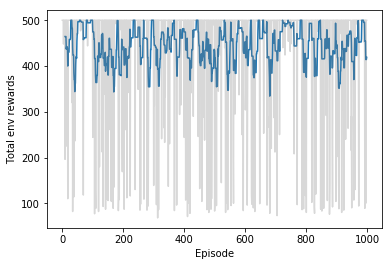

In [60]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total env rewards')

Text(0,0.5,'Total actions logits rewards')

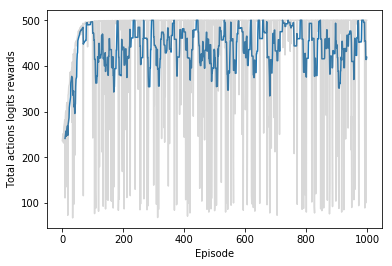

In [61]:
eps, arr = np.array(rewards2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions logits rewards')

Text(0,0.5,'Total actions labels/onehot rewards')

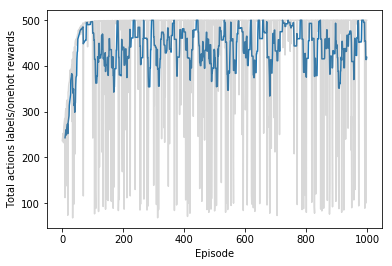

In [62]:
eps, arr = np.array(rewards3_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions labels/onehot rewards')

Text(0,0.5,'Gloss')

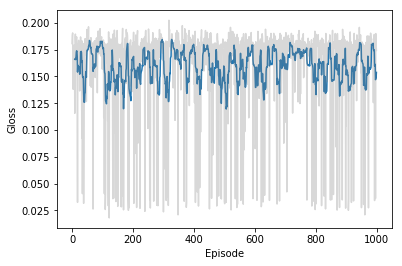

In [63]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Gloss')

Text(0,0.5,'Dloss')

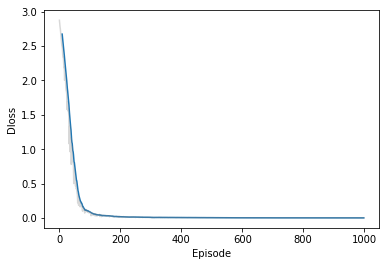

In [64]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Dloss')

In [73]:
# Env reward, action logits reward, action labels/onehot reward
rewards_list, rewards2_list, rewards3_list, gloss_list, dloss_list = [], [], [], [], []

# TF session for training
with tf.Session() as sess:
    
    # Rstoring/loading the trained/learned controller SA/SM
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-g-d.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    train_episodes = 100
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0 # reward env
        total_reward2 = 0 # reward action logits
        total_reward3 = 0 # reward action onehot/labels

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits, reward2, reward3 = sess.run([model.actions_logits, 
                                                        model.rewards2_logits, 
                                                        model.rewards3_logits],
                                                       feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                                  model.actions: np.array([action])})
                                                                  #model.actions: np.reshape(action, [-1])})
            #print(reward2[0, 0], reward3.reshape(-1))
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward # env
            total_reward2 += reward2[0, 0] #_action_logits
            total_reward3 += reward3[0, 0] #_actions_labels
            # state & action pair for policy learning: current policy/action
            # reward for adverserial/reward learning: current reward/value
            # reward2 and reward3 for value/Q learning: future rewards/value
            batch.append([state, action, reward, reward2[0, 0], reward3[0, 0]])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        rewards2 = np.array([each[3] for each in batch])
        rewards3 = np.array([each[4] for each in batch])
        g_loss, _ = sess.run([model.g_loss, model.g_opt], 
                             feed_dict = {model.states: states,
                                          model.actions: actions})
        d_loss, _ = sess.run([model.d_loss, model.gd_opt], 
                             feed_dict = {model.states: states,
                                          model.actions: actions, 
                                          model.rewards:rewards, 
                                          model.rewards2:rewards2, 
                                          model.rewards3:rewards3})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'total_reward2: {:.4f}'.format(total_reward2),
              'total_reward3: {:.4f}'.format(total_reward3),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        rewards_list.append([ep, total_reward])
        rewards2_list.append([ep, total_reward2])
        rewards3_list.append([ep, total_reward3])
        gloss_list.append([ep, g_loss])
        dloss_list.append([ep, d_loss])
        
    # Save the trained/learned D using G/SM/SA
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-g-d-gd.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/model-g-d.ckpt
Episode: 0 total_reward: 500.0 total_reward2: 499.9908 total_reward3: 499.9910 g_loss: 0.1802 d_loss: 0.0005
Episode: 1 total_reward: 500.0 total_reward2: 499.9868 total_reward3: 499.9865 g_loss: 0.1765 d_loss: 0.0007
Episode: 2 total_reward: 500.0 total_reward2: 499.9843 total_reward3: 499.9839 g_loss: 0.1629 d_loss: 0.0008
Episode: 3 total_reward: 500.0 total_reward2: 499.9847 total_reward3: 499.9841 g_loss: 0.1605 d_loss: 0.0008
Episode: 4 total_reward: 500.0 total_reward2: 499.9837 total_reward3: 499.9830 g_loss: 0.1631 d_loss: 0.0008
Episode: 5 total_reward: 163.0 total_reward2: 162.9967 total_reward3: 162.9966 g_loss: 0.0229 d_loss: 0.0005
Episode: 6 total_reward: 500.0 total_reward2: 499.9887 total_reward3: 499.9882 g_loss: 0.1521 d_loss: 0.0006
Episode: 7 total_reward: 173.0 total_reward2: 172.9963 total_reward3: 172.9962 g_loss: 0.0189 d_loss: 0.0005
Episode: 8 total_reward: 163.0 total_reward2: 162.9964 tota

Episode: 74 total_reward: 500.0 total_reward2: 499.9806 total_reward3: 499.9801 g_loss: 0.1469 d_loss: 0.0010
Episode: 75 total_reward: 500.0 total_reward2: 499.9911 total_reward3: 499.9912 g_loss: 0.1525 d_loss: 0.0005
Episode: 76 total_reward: 500.0 total_reward2: 499.9837 total_reward3: 499.9832 g_loss: 0.1487 d_loss: 0.0008
Episode: 77 total_reward: 500.0 total_reward2: 499.9813 total_reward3: 499.9809 g_loss: 0.1484 d_loss: 0.0009
Episode: 78 total_reward: 500.0 total_reward2: 499.9758 total_reward3: 499.9767 g_loss: 0.1530 d_loss: 0.0011
Episode: 79 total_reward: 500.0 total_reward2: 499.9867 total_reward3: 499.9863 g_loss: 0.1534 d_loss: 0.0007
Episode: 80 total_reward: 500.0 total_reward2: 499.9809 total_reward3: 499.9805 g_loss: 0.1402 d_loss: 0.0009
Episode: 81 total_reward: 500.0 total_reward2: 499.9748 total_reward3: 499.9756 g_loss: 0.1525 d_loss: 0.0012
Episode: 82 total_reward: 500.0 total_reward2: 499.9861 total_reward3: 499.9856 g_loss: 0.1506 d_loss: 0.0007
Episode: 8